# Links
https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/multi_agent/agent_supervisor.ipynb \
https://python.langchain.com/docs/integrations/tools/tavily_search/ \
https://tavily.com/ \
https://python.langchain.com/docs/integrations/chat/openai/

In [ ]:
#%%capture --no-stderr
#%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental
#%pip install -U langchain-openai

In [1]:
#imports

import getpass
import os
from dotenv import load_dotenv
import time
from typing import Annotated
from typing import Literal
from typing_extensions import TypedDict
from IPython.display import display, Image

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

#from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent



In [2]:
#get the keys
def _set_if_undefined(var: str):
    if not os.getenv(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")
        #print("API key error")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

## Create Tools

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

@tool
def search_for_business_insights(query: str) -> str:
    """
    Search the web for business insights, market trends, and competitive analysis to help with 
    creating a Value Proposition Canvas.
    
    Args:
        query: A search query related to business ideas, market analysis, customer needs, or competitors.
        
    Returns:
        Relevant information from the web that can help in developing a Value Proposition Canvas.
    """
    search_results = tavily_tool.invoke(query)
    
    # Format the results for better readability
    formatted_results = "## Web Search Results\n\n"
    for i, result in enumerate(search_results, 1):
        formatted_results += f"### Result {i}: {result.get('title', 'No Title')}\n"
        formatted_results += f"{result.get('content', 'No content available')}\n\n"
        formatted_results += f"Source: {result.get('url', 'No URL')}\n\n"
        formatted_results += "---\n\n"
    
    return formatted_results


#prompt loader
def load_prompt(file_name: str, name: str):
    with open(f"../prompts/{file_name}.txt", "r", encoding='utf-8') as file:
        name = file.read()
    return name

#load_prompt("Agent_A_test", "Agent_A_prompt")

## Create Agent Supervisor

In [4]:
members = ["Input_Checker", "VPC", "Output_Checker"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]



system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When ypu require,"
    " user input just output USER INPUT NEEDED"
    " if the input is valid and input agent says ACCEPTED forward it to the vpc_agent"
    " if the input agent says the input is INVALID respond with FINISH and tell the user the input is invalid."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## Prompts

In [5]:
VPC_prompt = load_prompt("prompt_VPC_CUT", "VPC_CUT_prompt") + "When you require user input (ie after your output) say USER INPUT NEEDED"


input_agent_prompt = load_prompt("Agent_A_test", "Agent_A_prompt")

output_agent_prompt = "You are output agent, you are supposed to oversee whether the supervisor provides sane output answering the users' query" + "If the VPC agent says USER INPUT NEEDED ONLY OUTPUT'USER INPUT NEEDED'"

task_prompt = "The user can give you a range of business ideas, normal ones like creating new types of toys to outlandish ones like organic gmo pet food for parrots. You should entertain these ideas as long as they are about the business idea and its value proposition (canvas) or VPC. If it deviates to other tasks then it is out of scope. Do not be extremely strict. If the input is INVALID say 'INVALID' and tell the user the input is invalid. Be very lenient with the user's input regaring things like the type of approaches."


## Construct Graph

In [6]:
input_agent = create_react_agent(
    llm, tools=[], prompt= input_agent_prompt + task_prompt
)

VPC_agent = create_react_agent(
    llm, tools=[search_for_business_insights], prompt= VPC_prompt    
)

output_agent = create_react_agent(
    llm, tools=[], prompt= output_agent_prompt
)

def input_node(state: State) -> Command[Literal["supervisor"]]:
    result = input_agent.invoke(state)
    

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="Input_Checker")
            ]
        },
        goto="VPC",
    )


def VPC_node(state: State) -> Command[Literal["supervisor"]]:
    result = VPC_agent.invoke(state)
    

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="VPC")
            ]
        },
        goto="supervisor",
    )


def output_node(state: State) -> Command[Literal["supervisor"]]:
    result = output_agent.invoke(state)
    

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="Output_Checker")
            ]
        },
        goto="supervisor",
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("VPC", VPC_node)
builder.add_node("Input_Checker", input_node)
builder.add_node("Output_Checker", output_node)
graph = builder.compile()

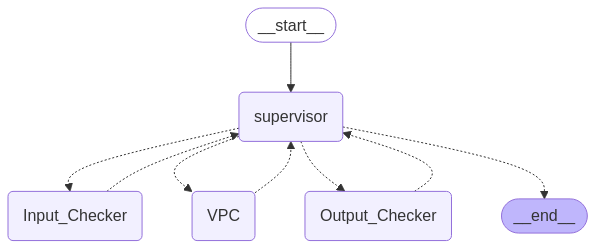

In [7]:
#Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

In [8]:
def run_simple(user_input: str):
    time_start = time.time()  
    for s in graph.stream(
        {"messages": [("user", user_input)]}, subgraphs=True
    ):
        if isinstance(s, tuple) and len(s) > 1:
            if "supervisor" in s[1] and "next" in s[1]["supervisor"]:
                print(f"Supervisor Next: {s[1]['supervisor']['next']}")
                print("----")
            
            # Extract agent messages
            agent_data = s[1].get("agent")
            if agent_data and "messages" in agent_data:
                for message in agent_data["messages"]:
                    print(f"Agent: {message.response_metadata.get('model_name', 'Unknown')}") #if model name is not available, print Unknown
                    print(f"Message: {message.content}")
                    time_end = time.time()
                    print(f"Time taken: {time_end - time_start}")
                    print("----")

In [9]:
#un_simple(" Hi, create me a VPC for an idea on building electronic devices out of paper")

In [14]:
def run_iter(user_input: str):
    # Just like run_simple but takes user input after each step when requested by the model.
    time_start = time.time()
    state = {"messages": [("user", user_input)]}
    
    # Continue processing until there is no new "USER INPUT" trigger.
    while True:
        user_input_triggered = False  # Flag to check if a "USER INPUT" prompt occurred.
        for s in graph.stream(state, subgraphs=True):
            if isinstance(s, tuple) and len(s) > 1:
                # Display supervisor routing info if available.
                if "supervisor" in s[1] and "next" in s[1]["supervisor"]:
                    print(f"Supervisor Next: {s[1]['supervisor']['next']}")
                    print("----")
                
                # Extract agent messages.
                agent_data = s[1].get("agent")
                if agent_data and "messages" in agent_data:
                    for message in agent_data["messages"]:
                        model_name = message.response_metadata.get('model_name', 'Unknown')
                        print(f"Agent: {model_name}")
                        print(f"Message: {message.content}")
                        time_end = time.time()
                        print(f"Time taken: {time_end - time_start}")
                        print("----")
                        # Check if the message contains a trigger for user input.
                        if ("USER INPUT NEEDED" in message.content 
                            or "REQUEST CLARIFICATION INPUT" in message.content 
                            or "INVALID" in message.content):
                            time.sleep(1)  # Small delay so that the message is visible.
                            new_input = input("Enter your response: ")
                            print("USER INPUT:", new_input)
                            print("----")
                            if new_input.lower() == "exit":
                                return
                            # Append the new user input to the existing messages for context.
                            state["messages"].append(("user", new_input))
                            user_input_triggered = True
                            # Break out of inner loop to resume streaming with the updated state.
                            break
                    if user_input_triggered:
                        # Break out of the outer stream loop if we just received new input.
                        break
        # Exit the loop if no new input was triggered.
        if not user_input_triggered:
            break

In [ ]:
run_iter(" Create me a VPC for an for building wooden electric mini race cars")

Supervisor Next: Input_Checker
----
Agent: gpt-4o-2024-08-06
Message: Create a Value Proposition Canvas (VPC) for building wooden electric mini race cars. ACCEPTED
Time taken: 1.5218274593353271
----
Agent: gpt-4o-2024-08-06
Message: To create a Value Proposition Canvas for your business idea of building wooden electric mini race cars, we will follow a structured process. Let's start with Step 1.

### Step 1: Customization of Approach and Uniqueness/Nicheness of Customers

Would you prefer a standard approach or a more creative approach for your business idea? A standard approach will focus on more common and general market segments while the creative approach will focus on niche or less well-known markets which might be smaller but also easier to target and saturate.

USER INPUT NEEDED
Time taken: 3.9427988529205322
----
USER INPUT: I like apples
----
Supervisor Next: Input_Checker
----
Agent: gpt-4o-2024-08-06
Message: [SORRY, INPUT DEVIATES FROM TASK. PLEASE TRY AGAIN]
Time taken: 8